In [18]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
bary_scenarios = ['mb2', 'illustris', 'eagle', 'HzAGN', 'TNG100', 'cowls_AGN', 'cowls_AGN_T8p5',
                      'cowls_AGN_T8p7', 'BAHAMAS', 'BAHAMAS_T7p6', 'BAHAMAS_T8p0']

def readCov(cov_fn):
    lines = np.genfromtxt(cov_fn)
    nd = np.max(lines[:,0]).astype(int)+1
    cov = np.zeros([nd, nd])
    for line in lines:
        i,j = int(line[0]), int(line[1])
        cg, cng = line[8], line[9]
        cov[i,j] = cg+cng
        cov[j,i] = cg+cng
    return cov

def generate_baryonic_PCA(cov_fn, data_vector_fmt, PCs_fn, write=False):
    cov = readCov(cov_fn)
    cov_L_cholesky = LA.cholesky(cov)
    inv_cov_L_cholesky = LA.inv(cov_L_cholesky)
    
    modelv_dm = np.genfromtxt(data_vector_fmt+"_dmo")[:,1]
    ndata_reduced = len(modelv_dm)
    nbaryons_scenario = len(bary_scenarios)
    baryon_diff = np.zeros(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        modelv_baryon = np.genfromtxt(data_vector_fmt+"_%s"%(bary_scenarios[i]))[:,1]
        baryon_diff[:,i] = (modelv_baryon-modelv_dm)

    baryon_weighted_diff = np.dot(inv_cov_L_cholesky, baryon_diff)

    U, Sdig, VT = LA.svd(baryon_weighted_diff, full_matrices=True)

    # MAKE SURE WHATEVER VERSION OF NP HAVE U IN THE RIGHT ORDER
    if(np.all(np.diff(Sdig) <= 0) != True):
        raise LoggedError(self.log, "LOGICAL ERROR WITH NUMPY FUNCTION GEN PCA")

    PCs = np.empty(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        PCs[:,i] = U[:,i]

    PCs = np.dot(cov_L_cholesky, PCs)

#     # Now we need to expand the number of dimensions
#     ndata = ci.get_ndim()
#     PCS_FINAL = np.empty(shape=(ndata, nbaryons_scenario))

#     for i in range(nbaryons_scenario):
#         PCS_FINAL[:,i] = ci.get_expand_dim_from_masked_reduced_dim(PCs[:,i])
    if write:
        np.savetxt(PCs_fn, PCs)

In [19]:
dvfmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15"
covfmt="/xdisk/timeifler/jiachuanxu/DESI2KL/cov/DESI2_KL_v2_%d%d_ssss_cov_Ncl15_Ntomo4"
PCs_fmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15.pca"

In [20]:
for i in range(6): # target selection
    for j in range(6): # shape noise (different weights)
        generate_baryonic_PCA(covfmt%(i,j), dvfmt%(i,0), PCs_fmt%(i,j), write=False)

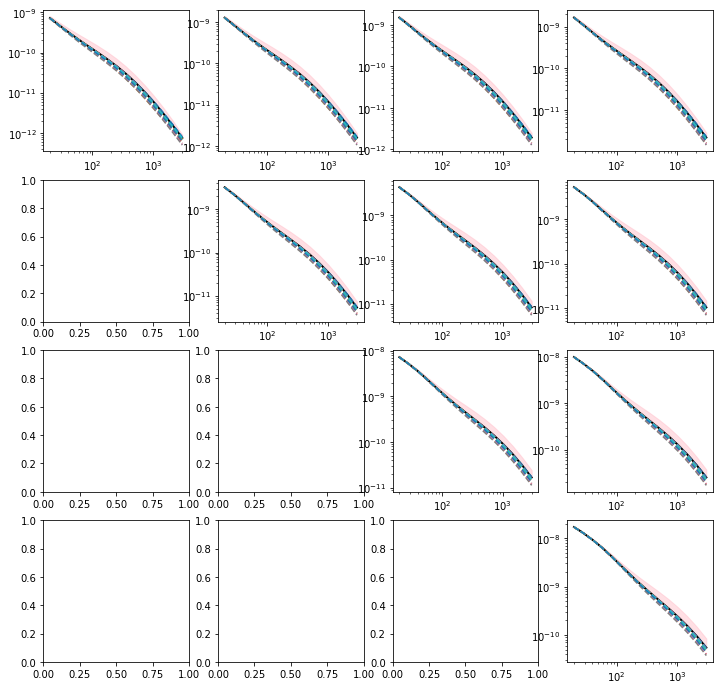

In [53]:
# examine some PCs
iSelect, iSN = 0, 3
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 4]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0], 
                        dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0], 
                        label='PC1', color='pink',alpha=0.5)
        ax.set(xscale='log', yscale='log',)
        ct += 15

In [32]:
# examine some PCs
iSelect, iSN = 0, 0
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 4]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,iSN)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0], 
                        dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0], 
                        label='PC1', color='pink',alpha=0.5)
        ax.set(xscale='log', yscale='log',)
        ct += 15

array([  20.        ,   28.60652374,   40.91666002,   58.52417031,
         83.70865336,  119.73067897,  171.25392552,  244.94897428,
        350.35693237,  501.12469514,  716.77177438, 1025.21743894,
       1466.39535022, 2097.4236698 , 3000.        ])

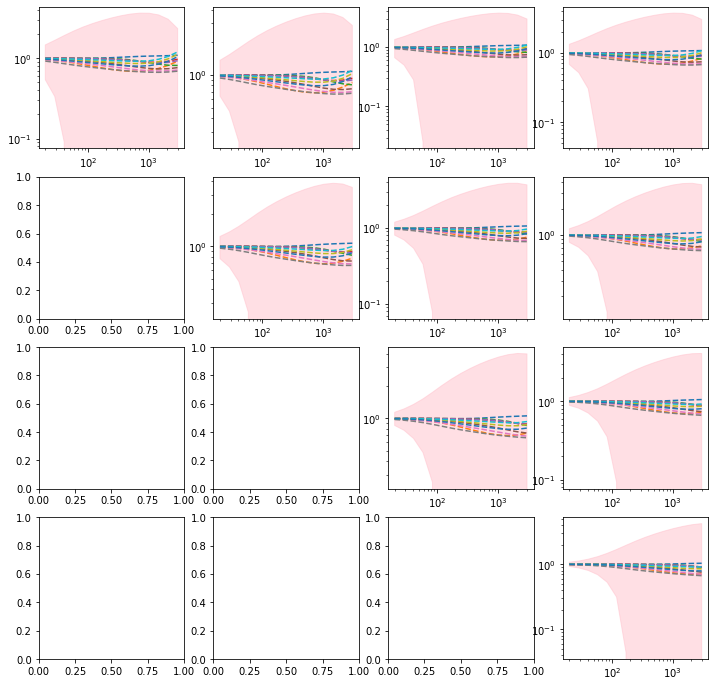

In [45]:
# examine some PCs
iSelect, iSN = 4,1
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [-4, 4]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        #ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1]/dv_dm[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        (dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        (dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        label='PC1', color='pink',alpha=0.5)
        ax.set(xscale='log', yscale='log',)
        ct += 15